# Machine Learning in Python - MNIST Fashion With Feature Engineering

## Data Prep

### Lots of Imports

To build predictive models in Python we use a set of libraries that are imported here. In particular **pandas** and **sklearn** are particularly important.

In [60]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline
#%qtconsole

### Setup 

Set a data sampling rate for speeding up testing

In [61]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches

In [62]:
cv_folds = 2

Set up a dictionary to store simple model perofrmance comparions

In [63]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

Load the dataset and explore it.

In [64]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
52171,1,0,0,0,0,0,0,0,0,0,...,148,0,0,0,0,0,0,0,0,0
10420,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6477,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59969,1,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0
4948,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the distribution of the two classes

In [65]:
dataset["label"].value_counts()
dataset.select_dtypes(include=[np.object]).shape[1]

0

In [66]:
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.463500,0.002333,0.004500,0.038500,0.137000,0.244500,0.46950,0.860000,2.231167,6.033833,...,35.217000,23.311333,16.442333,17.110833,21.545167,17.133167,8.312833,2.946333,0.903500,0.060000
std,2.872231,0.180739,0.164775,1.077131,3.300159,4.535616,7.04391,9.002254,14.260445,24.571759,...,58.035586,48.936209,42.140004,42.925773,50.177953,44.378670,29.148681,18.244733,9.513654,1.573048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,60.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,14.000000,10.000000,78.000000,150.000000,217.000000,188.00000,213.000000,218.000000,226.000000,...,253.000000,250.000000,254.000000,247.000000,255.000000,245.000000,226.000000,238.000000,199.000000,56.000000


In [67]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


Isolate the descriptive features we are interested in

In [68]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])


Display some of the images

[ 4566 ]  T-shirt/top


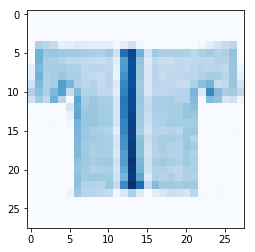

[ 3149 ]  Sandal


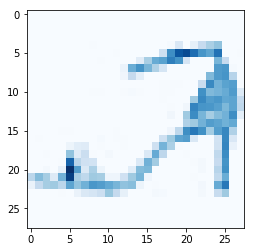

[ 5542 ]  Shirt


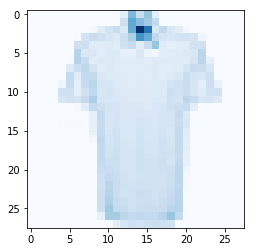

[ 3195 ]  T-shirt/top


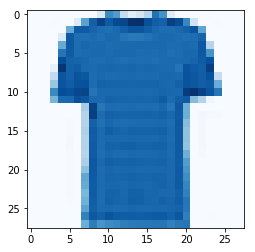

[ 5730 ]  Bag


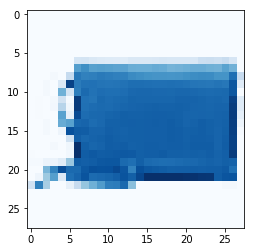

[ 3988 ]  Coat


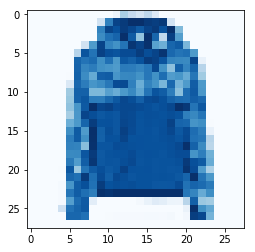

[ 1511 ]  Ankle boot


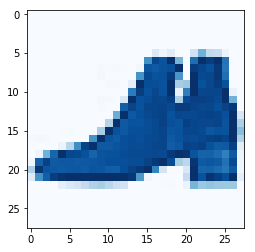

[ 2815 ]  Pullover


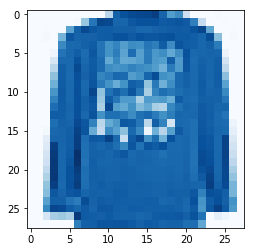

[ 1338 ]  Shirt


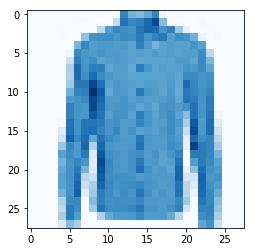

In [69]:
# create a sample of images from the dataset
for i in range(0, 9):
    i_rand = randint(0, X.shape[0])

    print("[", i_rand, "] ", classes[Y[i_rand]])
    two_d = (X.iloc[i_rand].values.reshape(28, 28))
    pyplot.imshow(two_d, cmap='Blues')
    pyplot.show()


Normalise the data (important for some models)

In [70]:
X = X/255


Extract some higher level features

In [71]:
engineered_features = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = X.sum(axis = 1)/(28*28)
percent_filled_top = X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features['percent_filled'] = percent_filled
engineered_features['percent_filled_top'] = percent_filled_top
engineered_features['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(X.iloc[:, 0:392]))

s2 = np.round(np.array(X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*14)

engineered_features['symmetry'] = symmetry

display(engineered_features.head(10))

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
52171,0.284289,0.279252,0.289326,0.254482,0.266246,0.270588,0.264146,0.271989,0.273669,0.274790,...,0.297059,0.298459,0.303641,0.302241,0.302101,0.303501,0.298599,0.322549,0.151401,0.265306
10420,0.065536,0.047199,0.083874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017857
6477,0.250925,0.177281,0.324570,0.000000,0.000000,0.000000,0.000000,0.000000,0.022549,0.087955,...,0.597059,0.308824,0.437535,0.204482,0.000000,0.000000,0.000000,0.000000,0.000000,0.186224
59969,0.205062,0.241807,0.168317,0.139776,0.312605,0.247899,0.268067,0.284454,0.296218,0.281092,...,0.165266,0.174930,0.179692,0.180252,0.179272,0.179552,0.168908,0.197759,0.089216,0.186224
4948,0.142382,0.094848,0.189916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027031,0.041317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096939
27748,0.267917,0.270188,0.265646,0.114006,0.274510,0.178852,0.197759,0.167647,0.270168,0.338235,...,0.297059,0.293557,0.290056,0.289636,0.300280,0.321709,0.242017,0.102941,0.091597,0.028061
26098,0.464286,0.504032,0.424540,0.083613,0.218207,0.345518,0.493277,0.557283,0.547479,0.554762,...,0.587955,0.589916,0.586695,0.613585,0.544258,0.029132,0.005322,0.024230,0.006583,0.395408
11154,0.277981,0.260724,0.295238,0.102381,0.227591,0.252241,0.282213,0.299300,0.269048,0.253081,...,0.316527,0.320028,0.331513,0.338515,0.366807,0.256583,0.246919,0.279552,0.155182,0.091837
34,0.366186,0.334144,0.398229,0.053081,0.156162,0.206583,0.259384,0.329692,0.400140,0.431232,...,0.437255,0.437815,0.419888,0.356162,0.352801,0.348599,0.345518,0.343978,0.326050,0.311224
10139,0.540786,0.596349,0.485224,0.025070,0.270168,0.591877,0.611064,0.633473,0.646359,0.662745,...,0.702521,0.511064,0.491176,0.459244,0.379412,0.368067,0.064566,0.078571,0.104062,0.492347


In [72]:
engineered_features['symmetry'].max()

0.7729591836734694

In [73]:
X = engineered_features

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [74]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Building Simple Models

### A Very Simple Decision Tree

Train a decision tree

In [75]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Evaluating Model Performance

Assess the performance of the decision tree on the training set

In [77]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       283
          1       1.00      1.00      1.00       305
          2       1.00      1.00      1.00       311
          3       1.00      1.00      1.00       319
          4       1.00      1.00      1.00       293
          5       1.00      1.00      1.00       312
          6       1.00      1.00      1.00       298
          7       1.00      1.00      1.00       289
          8       1.00      1.00      1.00       288
          9       1.00      1.00      1.00       302

avg / total       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,283,0,0,0,0,0,0,0,0,0,283
1,0,305,0,0,0,0,0,0,0,0,305
2,0,0,311,0,0,0,0,0,0,0,311
3,0,0,0,319,0,0,0,0,0,0,319
4,0,0,0,0,293,0,0,0,0,0,293
5,0,0,0,0,0,312,0,0,0,0,312
6,0,0,0,0,0,0,298,0,0,0,298
7,0,0,0,0,0,0,0,289,0,0,289
8,0,0,0,0,0,0,0,0,288,0,288


Assess the performance of the tree on the validation dataset

In [78]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6491666666666667
             precision    recall  f1-score   support

          0       0.61      0.59      0.60       119
          1       0.79      0.86      0.82       125
          2       0.45      0.46      0.46       112
          3       0.57      0.53      0.55       124
          4       0.57      0.57      0.57       124
          5       0.74      0.66      0.69       114
          6       0.37      0.39      0.38       119
          7       0.78      0.82      0.80       118
          8       0.84      0.80      0.82       133
          9       0.76      0.78      0.77       112

avg / total       0.65      0.65      0.65      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,70,6,5,9,3,3,22,0,1,0,119
1,3,108,4,6,1,0,3,0,0,0,125
2,2,4,52,9,21,0,21,0,0,3,112
3,11,13,9,66,7,1,12,0,1,4,124
4,3,4,19,10,71,0,16,0,1,0,124
5,3,1,0,4,0,75,1,18,6,6,114
6,19,0,23,11,14,0,46,0,4,2,119
7,0,0,0,0,0,12,1,97,1,7,118
8,2,1,3,0,3,6,2,3,107,6,133


Assess the performance of the tree on the validation dataset

In [79]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6016666666666667
             precision    recall  f1-score   support

          0       0.58      0.53      0.55       191
          1       0.81      0.77      0.79       191
          2       0.47      0.54      0.50       194
          3       0.47      0.45      0.46       183
          4       0.46      0.51      0.48       165
          5       0.72      0.69      0.71       177
          6       0.33      0.33      0.33       171
          7       0.74      0.80      0.77       183
          8       0.77      0.68      0.72       152
          9       0.72      0.69      0.71       193

avg / total       0.61      0.60      0.60      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,101,8,20,19,8,3,24,0,3,5,191
1,8,147,7,15,6,2,6,0,0,0,191
2,6,2,105,15,36,0,25,0,3,2,194
3,25,17,13,82,14,2,21,0,5,4,183
4,3,2,38,11,84,1,24,0,1,1,165
5,1,0,2,6,0,123,1,28,2,14,177
6,24,3,27,19,29,1,57,0,5,6,171
7,0,0,1,0,0,22,0,147,4,9,183
8,4,1,2,6,5,6,8,5,103,12,152


### Less Overiftted Decision Tree

Train a decision tree, setting min samples per leaf to a sensible value

In [80]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Assess the performance of the decision tree on the **training set**

In [81]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6143333333333333
             precision    recall  f1-score   support

          0       0.48      0.44      0.46       283
          1       0.65      0.80      0.72       305
          2       0.46      0.51      0.48       311
          3       0.53      0.58      0.55       319
          4       0.60      0.44      0.51       293
          5       0.79      0.70      0.74       312
          6       0.39      0.31      0.35       298
          7       0.72      0.83      0.77       289
          8       0.78      0.73      0.75       288
          9       0.72      0.80      0.76       302

avg / total       0.61      0.61      0.61      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,125,23,36,50,5,3,34,0,4,3,283
1,27,244,9,14,1,0,10,0,0,0,305
2,19,19,158,11,61,0,30,0,3,10,311
3,56,31,15,185,3,0,11,0,16,2,319
4,1,15,48,33,129,0,52,0,6,9,293
5,1,2,1,5,0,217,0,58,11,17,312
6,29,40,58,48,15,0,93,1,9,5,298
7,0,0,0,0,0,25,0,241,4,19,289
8,0,2,12,6,1,6,4,19,209,29,288


Assess the performance of the decision tree on the **validation set**

In [82]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.6008333333333333
             precision    recall  f1-score   support

          0       0.52      0.43      0.47       119
          1       0.67      0.83      0.74       125
          2       0.39      0.45      0.41       112
          3       0.49      0.58      0.53       124
          4       0.56      0.35      0.43       124
          5       0.78      0.71      0.74       114
          6       0.31      0.28      0.29       119
          7       0.75      0.81      0.78       118
          8       0.85      0.77      0.81       133
          9       0.66      0.79      0.72       112

avg / total       0.60      0.60      0.59      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,51,14,15,17,0,0,15,2,2,3,119
1,9,104,4,5,0,0,3,0,0,0,125
2,8,9,50,8,22,0,11,0,1,3,112
3,15,8,7,72,2,0,10,0,4,6,124
4,4,6,21,16,43,0,33,0,0,1,124
5,0,1,0,5,0,81,0,19,3,5,114
6,9,13,27,21,10,0,33,0,4,2,119
7,0,0,0,0,0,14,0,96,1,7,118
8,0,0,2,2,0,2,1,5,103,18,133


In [83]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.5811111111111111
             precision    recall  f1-score   support

          0       0.51      0.41      0.45       191
          1       0.67      0.80      0.73       191
          2       0.45      0.54      0.49       194
          3       0.43      0.47      0.45       183
          4       0.58      0.46      0.51       165
          5       0.74      0.66      0.70       177
          6       0.37      0.32      0.34       171
          7       0.71      0.75      0.73       183
          8       0.75      0.65      0.70       152
          9       0.61      0.74      0.67       193

avg / total       0.58      0.58      0.58      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,78,20,21,33,4,0,25,1,4,5,191
1,8,153,11,11,1,0,6,0,1,0,191
2,11,7,104,15,33,0,14,0,3,7,194
3,33,21,14,86,1,0,14,0,7,7,183
4,3,7,36,13,76,0,24,0,1,5,165
5,0,2,0,3,0,117,1,33,6,15,177
6,14,15,30,31,14,1,54,0,4,8,171
7,0,0,1,0,0,26,0,137,2,17,183
8,0,2,5,6,2,3,3,7,99,25,152


## Choosing Parameters Using a Grid Search

Use a cross validation to perfrom an evaluation

In [84]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[0.64941176 0.62028302 0.58865248 0.61045131 0.6547619  0.64047619
 0.62052506 0.63701923 0.63461538 0.62259615]


An alternative to using post pruning explicitly is to use a grid search through a large set of possible parameters. Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [85]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .......

[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.1s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.1s
Best parameters set found on development set:


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.0s finished


{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 200}

0.5714285714285714

{'mean_fit_time': array([0.02532506, 0.0382272 , 0.04199016, 0.03317487, 0.03084648,
        0.03152657, 0.03250754, 0.03091455, 0.05038905, 0.0452745 ,
        0.03412199, 0.03456795, 0.03083515, 0.03040802, 0.03279495,
        0.03075755, 0.05155718, 0.07676804, 0.07985556, 0.07959497,
        0.07532883, 0.07822955, 0.07764113, 0.07558751, 0.07790709,
        0.08363056, 0.08617246, 0.07968545, 0.09648347, 0.09617496,
        0.11171961, 0.11171222]),
 'mean_score_time': array([0.00101399, 0.00089347, 0.0017004 , 0.00081933, 0.0007602 ,
        0.00084996, 0.0007782 , 0.00079548, 0.00165844, 0.00108397,
        0.00082052, 0.00088   , 0.00077736, 0.00075758, 0.00085151,
        0.00077951, 0.00079536, 0.00077856, 0.00090587, 0.00083208,
        0.00080872, 0.00081956, 0.00085294, 0.00077546, 0.00079858,
        0.00078797, 0.00100505, 0.00078106, 0.001001  , 0.00087297,
        0.00170791, 0.00134134]),
 'mean_test_score': array([0.51642857, 0.57142857, 0.57142857, 0.57142857, 0.571

Evaluate the performance of the tuned tree

In [86]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5794444444444444
             precision    recall  f1-score   support

          0       0.69      0.32      0.44       191
          1       0.62      0.81      0.70       191
          2       0.53      0.40      0.45       194
          3       0.34      0.66      0.45       183
          4       0.59      0.55      0.57       165
          5       0.74      0.69      0.72       177
          6       0.32      0.22      0.26       171
          7       0.73      0.74      0.73       183
          8       0.80      0.70      0.75       152
          9       0.67      0.72      0.69       193

avg / total       0.60      0.58      0.57      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,62,30,9,64,6,0,14,0,3,3,191
1,0,155,5,30,1,0,0,0,0,0,191
2,2,12,77,37,26,0,36,0,1,3,194
3,13,29,7,120,4,0,5,0,3,2,183
4,0,7,31,20,90,0,14,0,2,1,165
5,0,1,0,6,0,123,0,29,5,13,177
6,11,17,15,60,16,2,37,0,4,9,171
7,0,0,0,0,0,27,0,135,1,20,183
8,2,1,1,6,5,2,3,8,106,18,152


Visualise the tree

In [88]:
best_tree = tree.DecisionTreeClassifier(min_samples_split=200, criterion='gini', max_depth=8)
best_tree = best_tree.fit(X_train, y_train)


## Comparing Models

We can easily use the same patterns to train other types of models.

#### Random Forests

Train and evaluate a simple model 

In [89]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.63
             precision    recall  f1-score   support

          0       0.64      0.43      0.51       119
          1       0.62      0.82      0.71       125
          2       0.49      0.46      0.47       112
          3       0.39      0.73      0.50       124
          4       0.52      0.61      0.57       124
          5       0.74      0.75      0.74       114
          6       0.00      0.00      0.00       119
          7       0.80      0.78      0.79       118
          8       0.91      0.86      0.88       133
          9       0.83      0.81      0.82       112

avg / total       0.59      0.63      0.60      1200

Confusion Matrix


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,1,2,3,4,5,7,8,9,All
True,,,,,,,,,,
0,51,31,6,25,2,2,0,2,0,119
1,4,103,0,18,0,0,0,0,0,125
2,2,7,52,26,24,0,0,1,0,112
3,9,12,6,90,4,1,0,2,0,124
4,0,5,17,26,76,0,0,0,0,124
5,0,0,0,7,0,86,16,1,4,114
6,14,8,22,37,33,0,0,4,1,119
7,0,0,0,0,0,18,92,0,8,118
8,0,0,2,0,2,3,5,115,6,133


Choose parameters using a grid search

In [91]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.6s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.7s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.9s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.8s
[CV] max_features=2, min_samples_sp

[CV]  max_features=8, min_samples_split=200, n_estimators=150, total=   1.0s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.3s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.3s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.5s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.8s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   2.2s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   2.3s
[CV] max_features=8, min_samples_sp

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.8min finished


Best parameters set found on development set:
{'max_features': 8, 'min_samples_split': 200, 'n_estimators': 450}
0.6114285714285714


In [93]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.645
             precision    recall  f1-score   support

          0       0.66      0.60      0.63       191
          1       0.78      0.83      0.81       191
          2       0.53      0.59      0.56       194
          3       0.46      0.63      0.53       183
          4       0.53      0.66      0.59       165
          5       0.71      0.73      0.72       177
          6       0.36      0.13      0.20       171
          7       0.79      0.74      0.77       183
          8       0.83      0.78      0.81       152
          9       0.76      0.72      0.74       193

avg / total       0.64      0.65      0.64      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,115,15,10,30,8,0,7,0,5,1,191
1,6,159,0,18,1,0,7,0,0,0,191
2,3,7,115,21,34,0,11,0,2,1,194
3,19,20,10,116,8,1,5,0,3,1,183
4,1,0,32,12,109,0,10,0,0,1,165
5,0,0,0,7,0,130,1,23,3,13,177
6,29,2,37,36,35,2,23,0,4,3,171
7,0,0,0,0,0,31,0,136,2,14,183
8,2,0,3,3,5,4,0,5,119,11,152


#### Bagging

Train and evaluate a simple model 

In [94]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [95]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6425
             precision    recall  f1-score   support

          0       0.60      0.63      0.61       119
          1       0.78      0.85      0.81       125
          2       0.50      0.47      0.48       112
          3       0.48      0.59      0.53       124
          4       0.53      0.62      0.57       124
          5       0.73      0.73      0.73       114
          6       0.37      0.18      0.24       119
          7       0.75      0.81      0.78       118
          8       0.90      0.77      0.83       133
          9       0.69      0.75      0.72       112

avg / total       0.64      0.64      0.63      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,75,9,7,12,1,0,10,2,1,2,119
1,5,106,1,13,0,0,0,0,0,0,125
2,6,4,53,9,28,0,10,0,1,1,112
3,14,11,7,73,5,4,6,0,0,4,124
4,2,3,11,22,77,0,7,0,1,1,124
5,0,0,0,5,0,83,2,19,0,5,114
6,21,3,22,15,30,1,21,0,4,2,119
7,0,0,0,0,0,14,0,96,1,7,118
8,0,0,2,1,2,4,1,5,103,15,133


Choose parameters using a grid search

In [96]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   1.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=No

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   0.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spl

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350, total=   7.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 400}
0.4116666666666667


In [97]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5727777777777778
             precision    recall  f1-score   support

          0       0.55      0.51      0.53       191
          1       0.61      0.83      0.70       191
          2       0.49      0.41      0.45       194
          3       0.41      0.50      0.45       183
          4       0.52      0.58      0.55       165
          5       0.70      0.70      0.70       177
          6       0.20      0.12      0.15       171
          7       0.73      0.74      0.73       183
          8       0.68      0.70      0.69       152
          9       0.69      0.65      0.67       193

avg / total       0.56      0.57      0.56      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,97,23,14,23,6,0,18,1,4,5,191
1,4,158,0,18,1,0,10,0,0,0,191
2,9,29,80,20,34,0,19,0,1,2,194
3,24,32,2,91,4,6,15,0,3,6,183
4,9,8,24,9,95,0,16,0,3,1,165
5,0,0,0,7,1,124,1,30,0,14,177
6,30,7,34,37,28,2,20,0,7,6,171
7,0,0,0,0,0,27,0,135,10,11,183
8,0,2,2,9,8,6,0,7,106,12,152


#### AdaBoost

Train and evaluate a simple model 

In [98]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)

In [99]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.42916666666666664
             precision    recall  f1-score   support

          0       0.27      0.28      0.27       119
          1       0.91      0.38      0.54       125
          2       0.35      0.36      0.35       112
          3       0.42      0.52      0.47       124
          4       0.24      0.17      0.20       124
          5       0.51      0.65      0.57       114
          6       0.22      0.39      0.28       119
          7       0.46      0.31      0.37       118
          8       0.63      0.81      0.71       133
          9       0.70      0.40      0.51       112

avg / total       0.47      0.43      0.43      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,33,2,7,31,14,0,29,0,2,1,119
1,46,48,5,17,7,0,2,0,0,0,125
2,9,0,40,6,19,0,37,0,1,0,112
3,12,3,10,64,8,1,25,0,1,0,124
4,8,0,24,14,21,0,56,0,1,0,124
5,2,0,0,4,0,74,1,22,4,7,114
6,10,0,24,15,18,1,46,0,4,1,119
7,0,0,0,0,0,62,0,36,17,3,118
8,1,0,0,0,2,2,11,2,108,7,133


Choose parameters using a grid search

In [100]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   2.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=No

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   2.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spl

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350, total=  14.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.9min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 400}
0.5914285714285714


In [101]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6188888888888889
             precision    recall  f1-score   support

          0       0.67      0.63      0.65       191
          1       0.91      0.80      0.85       191
          2       0.57      0.61      0.59       194
          3       0.51      0.53      0.52       183
          4       0.50      0.61      0.55       165
          5       0.72      0.45      0.55       177
          6       0.33      0.35      0.34       171
          7       0.59      0.82      0.69       183
          8       0.69      0.77      0.73       152
          9       0.82      0.62      0.71       193

avg / total       0.64      0.62      0.62      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,120,5,6,26,9,0,23,0,2,0,191
1,5,153,2,20,7,0,4,0,0,0,191
2,5,1,119,9,31,0,27,0,1,1,194
3,19,10,9,97,17,5,25,0,0,1,183
4,2,0,26,7,100,0,29,0,1,0,165
5,1,0,2,6,0,79,1,71,7,10,177
6,26,0,31,16,32,0,59,0,5,2,171
7,0,0,0,0,0,15,1,150,14,3,183
8,0,0,5,5,3,4,6,3,117,9,152


#### Logistic Regression

Train and evaluate a simple model 

In [102]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [103]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6625
             precision    recall  f1-score   support

          0       0.68      0.66      0.67       119
          1       0.75      0.90      0.82       125
          2       0.50      0.52      0.51       112
          3       0.54      0.68      0.60       124
          4       0.55      0.50      0.52       124
          5       0.67      0.72      0.69       114
          6       0.46      0.26      0.33       119
          7       0.82      0.82      0.82       118
          8       0.84      0.74      0.79       133
          9       0.75      0.81      0.78       112

avg / total       0.66      0.66      0.65      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,78,16,3,15,0,2,5,0,0,0,119
1,1,113,1,9,0,1,0,0,0,0,125
2,3,5,58,12,16,5,9,0,2,2,112
3,15,5,11,84,1,3,5,0,0,0,124
4,2,8,17,13,62,1,12,0,9,0,124
5,0,0,0,8,0,82,0,15,1,8,114
6,15,3,18,12,28,7,31,0,4,1,119
7,0,0,0,0,0,15,0,97,1,5,118
8,0,0,2,3,6,2,1,5,99,15,133


Choose parameters using a grid search

In [104]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Logistic Regression"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=1.0, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=1.0, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=1.0, max_iter=1000, multi_cl

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.3s finished


Best parameters set found on development set:
{'C': 1.8, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.6309523809523809


In [105]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6277777777777778
             precision    recall  f1-score   support

          0       0.70      0.58      0.63       191
          1       0.69      0.88      0.78       191
          2       0.49      0.55      0.52       194
          3       0.49      0.54      0.51       183
          4       0.51      0.53      0.52       165
          5       0.67      0.69      0.68       177
          6       0.40      0.27      0.33       171
          7       0.78      0.79      0.78       183
          8       0.76      0.70      0.73       152
          9       0.76      0.73      0.74       193

avg / total       0.62      0.63      0.62      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,110,23,13,24,4,2,6,1,8,0,191
1,3,169,2,16,0,0,1,0,0,0,191
2,3,9,106,19,33,0,20,0,3,1,194
3,14,32,11,98,6,7,13,0,1,1,183
4,2,4,34,11,87,2,16,0,8,1,165
5,1,0,1,6,0,122,2,25,1,19,177
6,24,6,26,24,33,6,47,0,3,2,171
7,0,0,0,0,1,27,0,144,0,11,183
8,0,1,2,3,6,9,6,8,107,10,152


#### Nearest Neighbour

Train and evaluate a simple model 

In [106]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

In [107]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7233333333333334
             precision    recall  f1-score   support

          0       0.71      0.61      0.65       119
          1       0.77      0.96      0.85       125
          2       0.53      0.61      0.57       112
          3       0.61      0.73      0.67       124
          4       0.63      0.57      0.60       124
          5       0.82      0.74      0.78       114
          6       0.50      0.42      0.45       119
          7       0.86      0.89      0.88       118
          8       0.96      0.81      0.88       133
          9       0.84      0.88      0.86       112

avg / total       0.73      0.72      0.72      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,72,15,7,11,1,1,10,0,2,0,119
1,1,120,0,3,0,0,1,0,0,0,125
2,1,3,68,5,19,0,15,0,0,1,112
3,4,13,8,91,2,0,6,0,0,0,124
4,3,5,16,12,71,0,16,0,0,1,124
5,1,0,0,10,0,84,1,10,1,7,114
6,18,0,24,10,15,0,50,0,1,1,119
7,0,0,0,0,0,11,0,105,0,2,118
8,0,0,3,3,4,2,0,6,108,7,133


Choose parameters using a grid search

In [108]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.1s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   0.1s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.1s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.1s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   0.2s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   0.1s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.2s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.2s
[CV] n_neighbors=21 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


In [109]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6933333333333334
             precision    recall  f1-score   support

          0       0.70      0.69      0.69       191
          1       0.76      0.93      0.83       191
          2       0.56      0.63      0.59       194
          3       0.59      0.58      0.59       183
          4       0.56      0.62      0.59       165
          5       0.76      0.71      0.73       177
          6       0.46      0.35      0.39       171
          7       0.85      0.79      0.82       183
          8       0.96      0.79      0.87       152
          9       0.76      0.82      0.79       193

avg / total       0.69      0.69      0.69      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,131,16,6,17,6,0,13,0,2,0,191
1,3,177,1,7,0,0,3,0,0,0,191
2,5,5,122,5,31,0,21,0,0,5,194
3,13,30,11,107,8,0,13,0,0,1,183
4,2,1,33,12,103,0,13,0,0,1,165
5,1,0,1,7,0,126,2,18,1,21,177
6,29,4,36,14,25,0,59,0,0,4,171
7,0,0,0,0,1,26,0,145,0,11,183
8,1,0,3,5,5,2,3,6,120,7,152


### Multi Layer Perceptron

Train and evaluate a simple model 

In [110]:
# Do the same job with random forests
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_model = my_model.fit(X_train,y_train)

In [111]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7275
             precision    recall  f1-score   support

          0       0.75      0.70      0.72       119
          1       0.96      0.87      0.91       125
          2       0.50      0.62      0.56       112
          3       0.58      0.80      0.67       124
          4       0.71      0.57      0.63       124
          5       0.71      0.85      0.78       114
          6       0.45      0.34      0.39       119
          7       0.92      0.78      0.84       118
          8       0.92      0.88      0.90       133
          9       0.85      0.84      0.85       112

avg / total       0.74      0.73      0.73      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,83,2,7,13,0,1,11,0,2,0,119
1,0,109,1,13,0,0,2,0,0,0,125
2,2,0,70,6,11,0,19,0,1,3,112
3,9,2,8,99,0,2,4,0,0,0,124
4,2,1,19,18,71,0,13,0,0,0,124
5,0,0,0,6,0,97,0,6,2,3,114
6,15,0,26,15,17,2,41,0,2,1,119
7,0,0,0,0,0,22,0,92,0,4,118
8,0,0,3,1,1,4,0,2,117,5,133


Choose parameters using a grid search

In [112]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................
[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   3.0s
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   2.9s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   5.6s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   3.8s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=   4.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=   5.4s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................
[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   4.6s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................
[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   3.1s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.7min finished


Best parameters set found on development set:
{'alpha': 0.0001, 'hidden_layer_sizes': (400, 200)}
0.7114285714285714


In [113]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7272222222222222
             precision    recall  f1-score   support

          0       0.70      0.81      0.75       191
          1       0.87      0.90      0.89       191
          2       0.58      0.61      0.59       194
          3       0.74      0.62      0.67       183
          4       0.58      0.62      0.60       165
          5       0.75      0.85      0.80       177
          6       0.48      0.45      0.47       171
          7       0.88      0.81      0.85       183
          8       0.92      0.78      0.84       152
          9       0.81      0.80      0.81       193

avg / total       0.73      0.73      0.73      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,154,5,8,8,5,3,7,0,1,0,191
1,3,172,1,11,1,0,3,0,0,0,191
2,4,2,118,4,30,0,31,0,0,5,194
3,23,17,6,113,12,3,7,0,0,2,183
4,1,0,30,7,102,0,25,0,0,0,165
5,1,0,2,1,0,151,2,10,1,9,177
6,31,1,30,6,21,0,77,0,4,1,171
7,0,0,0,0,1,22,0,149,1,10,183
8,2,0,2,2,3,6,4,6,119,8,152


### Compare Results

In [114]:
display(model_test_accuracy_comparisons)

{'Better Tree': 0.5811111111111111,
 'Simple Tree': 0.6016666666666667,
 'Tuned AdaBoost': 0.6188888888888889,
 'Tuned Bagging': 0.5727777777777778,
 'Tuned Logistic Regression': 0.6277777777777778,
 'Tuned MLP': 0.7272222222222222,
 'Tuned Random Forest': 0.645,
 'Tuned Tree': 0.5794444444444444,
 'Tuned kNN': 0.6933333333333334}

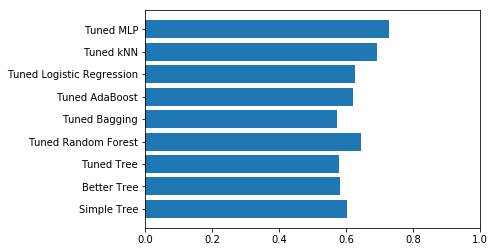

In [115]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [116]:
display(model_valid_accuracy_comparisons)

{'AdaBoost': 0.42916666666666664,
 'Bagging': 0.6425,
 'Better Tree': 0.6008333333333333,
 'Logistic Regression': 0.6625,
 'MLP': 0.7275,
 'Random Forest': 0.63,
 'Simple Tree': 0.6491666666666667,
 'kNN': 0.7233333333333334}

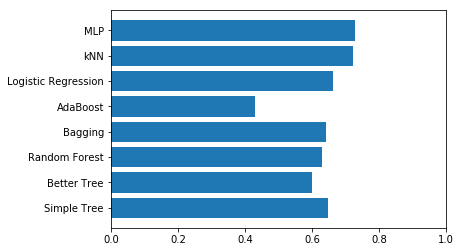

In [117]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

### Test Best Model On Test Dataset

In [118]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [120]:
test_X = test_X/255

In [121]:
engineered_features_test = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = test_X.sum(axis = 1)/(28*28)
percent_filled_top = test_X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = test_X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features_test['percent_filled'] = percent_filled
engineered_features_test['percent_filled_top'] = percent_filled_top
engineered_features_test['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = test_X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features_test["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(test_X.iloc[:, 0:392]))
s2 = np.round(np.array(test_X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*14)

engineered_features_test['symmetry'] = symmetry

display(engineered_features_test.head(10))

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
0,0.399620,0.422389,0.376851,0.018347,0.078992,0.185994,0.414286,0.550840,0.540196,0.518347,...,0.388235,0.391737,0.395098,0.395938,0.400560,0.393697,0.370728,0.457843,0.212745,0.323980
1,0.210664,0.236134,0.185194,0.209664,0.250000,0.267647,0.291877,0.267787,0.248880,0.240756,...,0.199160,0.201821,0.199860,0.202941,0.198039,0.191317,0.185294,0.185294,0.155742,0.168367
2,0.168382,0.193377,0.143387,0.051961,0.157563,0.267507,0.189076,0.192577,0.219328,0.205462,...,0.211345,0.240196,0.157423,0.139216,0.113165,0.079272,0.072129,0.028291,0.038375,0.020408
3,0.407893,0.460554,0.355232,0.257143,0.455602,0.452101,0.430532,0.433053,0.462465,0.500560,...,0.374510,0.319888,0.264146,0.236835,0.277311,0.257423,0.475070,0.725350,0.445798,0.206633
4,0.252716,0.325090,0.180342,0.007563,0.281092,0.360924,0.362745,0.369328,0.381933,0.343277,...,0.251261,0.259664,0.216527,0.034594,0.026751,0.017647,0.016387,0.010364,0.010364,0.158163
5,0.270638,0.251210,0.290066,0.047479,0.181513,0.237255,0.223389,0.230952,0.228011,0.247899,...,0.271849,0.238515,0.256162,0.267647,0.272829,0.282353,0.298599,0.286975,0.188375,0.020408
6,0.404432,0.368958,0.439906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.395098,...,0.780532,0.792997,0.885714,0.123950,0.000000,0.000000,0.000000,0.000000,0.000000,0.405612
7,0.290756,0.255282,0.326230,0.045238,0.160784,0.236835,0.185854,0.223389,0.243417,0.255462,...,0.346359,0.344398,0.332773,0.324790,0.347059,0.280532,0.261485,0.311204,0.283193,0.104592
8,0.167462,0.139776,0.195148,0.000000,0.030952,0.163165,0.316947,0.357843,0.205042,0.085294,...,0.124790,0.178571,0.183333,0.178011,0.339916,0.399860,0.423249,0.176331,0.000000,0.066327
9,0.215581,0.257233,0.173930,0.046218,0.245238,0.248319,0.227731,0.203221,0.267227,0.389776,...,0.175350,0.173389,0.176611,0.185014,0.180952,0.190616,0.192297,0.224090,0.107423,0.000000


In [122]:
test_X = engineered_features_test

In [131]:
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(400, 200))
my_model = my_model.fit(X,Y)

In [132]:
# Make a set of predictions for the test data
y_pred = my_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7535
             precision    recall  f1-score   support

          0       0.70      0.74      0.72      1000
          1       0.91      0.92      0.92      1000
          2       0.66      0.58      0.62      1000
          3       0.74      0.70      0.72      1000
          4       0.67      0.66      0.66      1000
          5       0.81      0.83      0.82      1000
          6       0.48      0.54      0.51      1000
          7       0.84      0.86      0.85      1000
          8       0.93      0.85      0.89      1000
          9       0.84      0.84      0.84      1000

avg / total       0.76      0.75      0.75     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,744,9,28,75,13,11,101,2,16,1,1000
1,15,922,10,42,5,1,5,0,0,0,1000
2,26,2,585,19,170,6,170,0,6,16,1000
3,75,69,23,700,40,17,70,1,4,1,1000
4,11,4,98,43,662,3,172,1,3,3,1000
5,4,0,1,13,1,835,13,83,9,41,1000
6,169,9,118,50,88,7,538,3,12,6,1000
7,0,0,0,0,0,68,0,864,3,65,1000
8,15,0,21,7,10,26,32,12,846,31,1000


In [129]:
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X,Y)

In [130]:
# Make a set of predictions for the test data
y_pred = my_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7106
             precision    recall  f1-score   support

          0       0.69      0.69      0.69      1000
          1       0.78      0.94      0.85      1000
          2       0.59      0.63      0.61      1000
          3       0.63      0.66      0.64      1000
          4       0.63      0.60      0.62      1000
          5       0.81      0.68      0.74      1000
          6       0.49      0.44      0.47      1000
          7       0.80      0.83      0.81      1000
          8       0.94      0.79      0.86      1000
          9       0.76      0.85      0.80      1000

avg / total       0.71      0.71      0.71     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,689,53,33,95,14,2,100,2,12,0,1000
1,9,945,9,31,2,1,3,0,0,0,1000
2,18,23,631,34,158,1,115,0,7,13,1000
3,73,131,28,657,36,2,69,0,2,2,1000
4,13,11,183,65,602,1,118,0,3,4,1000
5,10,1,8,43,3,677,24,136,8,90,1000
6,163,47,140,83,106,1,443,0,12,5,1000
7,0,0,0,0,0,84,0,827,1,88,1000
8,15,0,30,16,23,35,13,15,788,65,1000


### Hence we see that we get the best accuracy for the Engineered model when we use MLP with the prams obtained during the grid search